## Next word prediction with BERT

- Improved code with a lower learning rate: The learning rate can significantly affect training. If it's too high, the model might overshoot the optimal weights. If it's too low, training might be too slow, or the model might get stuck in local minima. In this code, I changed the experiment with a lower learning rate.
- Using a different example data for training and testing the Masked Language Model (MLM) task. Although training and testing on the same data can lead to overfitting, I am using the same data for the simplicity and debugging of the experiment.

**References**
<br>BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (https://arxiv.org/pdf/1810.04805.pdf)
<br>neptune.ai blog: https://neptune.ai/blog/how-to-code-bert-using-pytorch-tutorial
<br> original code by Tae Hwan Jung: https://github.com/graykode/nlp-tutorial/blob/master/5-2.BERT/BERT.py

### Required Packages

In [1]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

### Preprocessing data

In [2]:
text = (
       '"Hey, Mike! Long time no see," exclaimed Sarah as she spotted him in the cafe\n'
       'Mike looked up and smiled, "Sarah! It\'s been ages. How have you been?"\n'
       '"I\'ve been doing well. Just got back from a trip to Spain," she replied, taking a seat\n'
       '"Oh, that sounds amazing! How was it?" he inquired, genuinely curious\n'
       '"It was incredible. The culture, food, everything was just perfect," she reminisced\n'
       'Mike chuckled, "I\'m a bit jealous now"\n'
       '"You should definitely visit someday," Sarah suggested\n'
       '"I\'ll keep that in mind," he nodded\n'
       '"Let\'s catch up more. I\'ve missed our chats," she said warmly\n'
       '"Absolutely, there\'s a lot to share," Mike agreed\n'
   )

In [3]:
print (text)

"Hey, Mike! Long time no see," exclaimed Sarah as she spotted him in the cafe
Mike looked up and smiled, "Sarah! It's been ages. How have you been?"
"I've been doing well. Just got back from a trip to Spain," she replied, taking a seat
"Oh, that sounds amazing! How was it?" he inquired, genuinely curious
"It was incredible. The culture, food, everything was just perfect," she reminisced
Mike chuckled, "I'm a bit jealous now"
"You should definitely visit someday," Sarah suggested
"I'll keep that in mind," he nodded
"Let's catch up more. I've missed our chats," she said warmly
"Absolutely, there's a lot to share," Mike agreed



- Removes punctuations, converts it to lowercase, and splits it into a list of sentences.
- Creates a list of unique words from those sentences.

In [4]:
sentences = re.sub("[.,!?\\-]", '', text.lower()).split('\n')  # filter '.', ',', '?', '!'
word_list = list(set(" ".join(sentences).split()))

In [6]:
sentences
#word_list

['"hey mike long time no see" exclaimed sarah as she spotted him in the cafe',
 'mike looked up and smiled "sarah it\'s been ages how have you been"',
 '"i\'ve been doing well just got back from a trip to spain" she replied taking a seat',
 '"oh that sounds amazing how was it" he inquired genuinely curious',
 '"it was incredible the culture food everything was just perfect" she reminisced',
 'mike chuckled "i\'m a bit jealous now"',
 '"you should definitely visit someday" sarah suggested',
 '"i\'ll keep that in mind" he nodded',
 '"let\'s catch up more i\'ve missed our chats" she said warmly',
 '"absolutely there\'s a lot to share" mike agreed',
 '']

**Token and purpose:**

[CLS] The first token is classification

[SEP] Separates two sentences

[END] End the sentence

[PAD] Truncate the sentences with equal length

[MASK] Creates a mask by replacing the original word

>This code: 
<br>Creates word_dict, a dictionary of special tokens.
<br>Adds each unique word from word_list to the dictionary with a unique integer value.
<br>Creates a reverse dictionary where the keys and values are swapped.
<br>Calculates the total number of unique words in the dictionary.

In [7]:
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}

for i, w in enumerate(word_list):
    word_dict[w] = i + 4
    number_dict = {i: w for i, w in enumerate(word_dict)}
    vocab_size = len(word_dict)
vocab_size

91

In [8]:
word_dict

{'[PAD]': 0,
 '[CLS]': 1,
 '[SEP]': 2,
 '[MASK]': 3,
 'seat': 4,
 'to': 5,
 'time': 6,
 'mike': 7,
 'was': 8,
 'up': 9,
 'ages': 10,
 'definitely': 11,
 'agreed': 12,
 'food': 13,
 'he': 14,
 'keep': 15,
 'the': 16,
 'you': 17,
 'well': 18,
 '"i\'m': 19,
 'mind"': 20,
 'visit': 21,
 'exclaimed': 22,
 'long': 23,
 'a': 24,
 'bit': 25,
 'now"': 26,
 'nodded': 27,
 'more': 28,
 'said': 29,
 '"it': 30,
 'replied': 31,
 'should': 32,
 'chuckled': 33,
 'incredible': 34,
 'reminisced': 35,
 'back': 36,
 'perfect"': 37,
 'she': 38,
 'missed': 39,
 'looked': 40,
 'in': 41,
 'trip': 42,
 'genuinely': 43,
 'been"': 44,
 'from': 45,
 'smiled': 46,
 'jealous': 47,
 'it"': 48,
 'doing': 49,
 'curious': 50,
 '"i\'ve': 51,
 '"you': 52,
 'culture': 53,
 "there's": 54,
 'spotted': 55,
 '"i\'ll': 56,
 'have': 57,
 'him': 58,
 'someday"': 59,
 'sounds': 60,
 'suggested': 61,
 'spain"': 62,
 'share"': 63,
 'that': 64,
 'chats"': 65,
 '"sarah': 66,
 'everything': 67,
 'see"': 68,
 'taking': 69,
 'catch': 70

### Taking care of three types of embedding

- Token embedding
- Segment embedding
- Position embedding

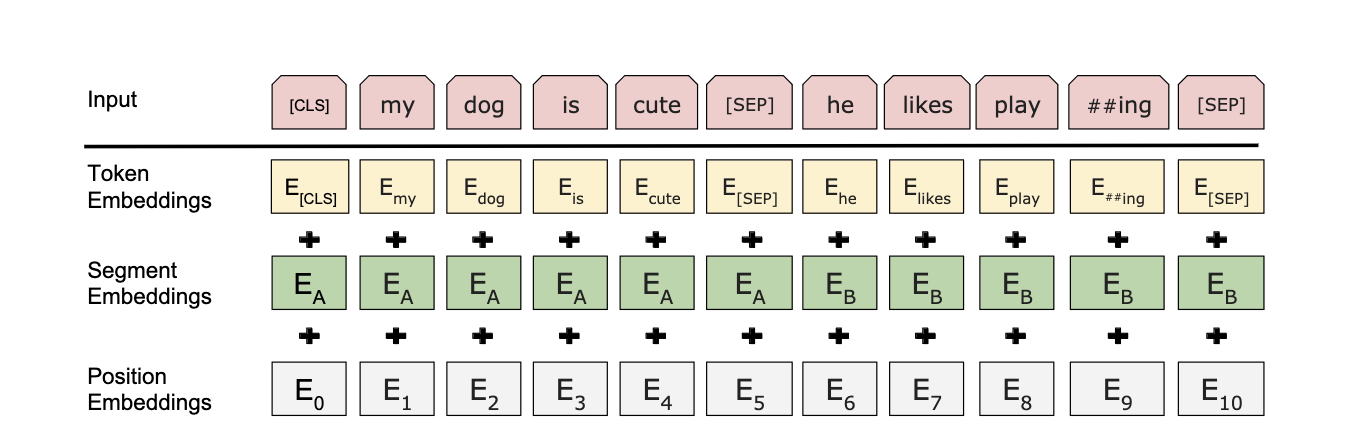
source: https://arxiv.org/pdf/1810.04805.pdf

- Token_list is a list of lists
- Each inner list represents a sentence from `sentences`
- Instead of words, it will contain integer values that map to those words based on the `word_dict` dictionary

In [9]:
token_list = list()
for sentence in sentences:
    arr = [word_dict[s] for s in sentence.split()]
    token_list.append(arr)

In [10]:
word_dict

{'[PAD]': 0,
 '[CLS]': 1,
 '[SEP]': 2,
 '[MASK]': 3,
 'seat': 4,
 'to': 5,
 'time': 6,
 'mike': 7,
 'was': 8,
 'up': 9,
 'ages': 10,
 'definitely': 11,
 'agreed': 12,
 'food': 13,
 'he': 14,
 'keep': 15,
 'the': 16,
 'you': 17,
 'well': 18,
 '"i\'m': 19,
 'mind"': 20,
 'visit': 21,
 'exclaimed': 22,
 'long': 23,
 'a': 24,
 'bit': 25,
 'now"': 26,
 'nodded': 27,
 'more': 28,
 'said': 29,
 '"it': 30,
 'replied': 31,
 'should': 32,
 'chuckled': 33,
 'incredible': 34,
 'reminisced': 35,
 'back': 36,
 'perfect"': 37,
 'she': 38,
 'missed': 39,
 'looked': 40,
 'in': 41,
 'trip': 42,
 'genuinely': 43,
 'been"': 44,
 'from': 45,
 'smiled': 46,
 'jealous': 47,
 'it"': 48,
 'doing': 49,
 'curious': 50,
 '"i\'ve': 51,
 '"you': 52,
 'culture': 53,
 "there's": 54,
 'spotted': 55,
 '"i\'ll': 56,
 'have': 57,
 'him': 58,
 'someday"': 59,
 'sounds': 60,
 'suggested': 61,
 'spain"': 62,
 'share"': 63,
 'that': 64,
 'chats"': 65,
 '"sarah': 66,
 'everything': 67,
 'see"': 68,
 'taking': 69,
 'catch': 70

In [11]:
token_list

[[90, 7, 23, 6, 83, 68, 22, 71, 81, 38, 55, 58, 41, 16, 87],
 [7, 40, 9, 82, 46, 66, 85, 89, 10, 86, 57, 17, 44],
 [51, 89, 49, 18, 80, 84, 36, 45, 24, 42, 5, 62, 38, 31, 69, 24, 4],
 [74, 64, 60, 72, 86, 8, 48, 14, 76, 43, 50],
 [30, 8, 34, 16, 53, 13, 67, 8, 80, 37, 38, 35],
 [7, 33, 19, 24, 25, 47, 26],
 [52, 32, 11, 21, 59, 71, 61],
 [56, 15, 64, 41, 20, 14, 27],
 [73, 70, 9, 28, 77, 39, 79, 65, 38, 29, 88],
 [78, 54, 24, 75, 5, 63, 7, 12],
 []]

In [12]:
sentences

['"hey mike long time no see" exclaimed sarah as she spotted him in the cafe',
 'mike looked up and smiled "sarah it\'s been ages how have you been"',
 '"i\'ve been doing well just got back from a trip to spain" she replied taking a seat',
 '"oh that sounds amazing how was it" he inquired genuinely curious',
 '"it was incredible the culture food everything was just perfect" she reminisced',
 'mike chuckled "i\'m a bit jealous now"',
 '"you should definitely visit someday" sarah suggested',
 '"i\'ll keep that in mind" he nodded',
 '"let\'s catch up more i\'ve missed our chats" she said warmly',
 '"absolutely there\'s a lot to share" mike agreed',
 '']

### Setting up hyperparameters for the transformer architecture

In [13]:
if __name__ == '__main__':
    maxlen = 95 # maximum sequence length
    batch_size = 6 # how many samples are used in one forward/backward pass (one step of gradient descent) before updating the model's weights
    max_pred = 5  # max tokens of prediction
    n_layers = 6 # number of Encoder of Encoder Layer
    n_heads = 12 # number of heads in Multi-Head Attention
    d_model = 768 # Embedding Size
    d_ff = 768 * 4  # 4*d_model, FeedForward dimension
    d_k = d_v = 64  # dimension of Key(=Q),  and Value in the attention mechanism [768/12=64]
    n_segments = 2 #  2 implies that the model can handle pair-input task

>**Function for preparing data for the BERT pre-training task**
<br>The model learns to predict masked tokens and determine whether two sentences are consecutive or not.

- Masked Language Modeling (MLM) Task:
  - 80% of the time: Replace the token with [MASK]
  - 10% of the time: Replace the token with a random token
  - 10% of the time: Keep the token unchanged
        
- Padding:
    - If the concatenated sentence pair is shorter than max length, it pads the sequence with zeros.
    - Similarly, it pads the masked_tokens and masked_pos lists if fewer tokens were masked than max_pred.

In [14]:
def make_batch():
    batch = []
    positive = negative = 0
    
    # create a batch that contains an equal number of positive and negative samples.
    while positive != batch_size/2 or negative != batch_size/2:
        tokens_a_index, tokens_b_index= randrange(len(sentences)), randrange(len(sentences))
        
        # randomly selecting a tokenized sentence from the token_list and assigning it to variables
        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]

        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]
        
        # Creating zeros for positions belonging to the first sequence (tokens_a) and ones for the second sequence (tokens_b)
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        
        # MASK LM
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence
        cand_maked_pos = [i for i, token in enumerate(input_ids)
                         if token != word_dict['[CLS]'] and token != word_dict['[SEP]']] # excludes the positions of special tokens [CLS] and [SEP] 
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            
            #    80% chance to replace with [MASK] token
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
                
            # 10% chance to replace with a random token from the vocabulary
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace
                
            # "do nothing" for approximately 10% of the time

        # Sentence Zero Paddings
        # This is done because deep learning models often require fixed-size input arrays. By padding shorter sequences with zeros, all input sequences can be made to fit the model's expected input size.
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Masked tokens Zero Padding (100% - 15%) tokens
        # This ensures that, regardless of how many tokens were actually masked in a particular sequence, the lists representing the masked tokens and their positions always have a consistent, expected length (max_pred).
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)
            
        # If the index of tokens_b is exactly one greater than the index of tokens_a, then tokens_b directly follows tokens_a
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
            
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
    return batch

### Building Model

>The get_attn_pad_mask function creates a mask to ensure that the attention mechanism does not pay attention to padding tokens when computing attention weights. The mask has a value of True at positions corresponding to padding tokens and False elsewhere.

In [15]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

- Using gelu (Gaussian Error Linear Unit) activation function 

In [16]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [17]:
batch = make_batch()

In [18]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))


In [19]:
get_attn_pad_mask(input_ids, input_ids)[0][0], input_ids[0]

(tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True]),
 tensor([ 1, 74,  3, 60, 72,  3,  8, 48, 14, 76, 43, 50,  2, 90, 32, 23,  6, 83,
         68, 22, 71, 81, 38, 55, 58, 41, 16, 87,  2,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,


In [20]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [21]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]

In [23]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(gelu(self.fc1(x)))


In [24]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [25]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled) # [batch_size, 2]

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf

In [26]:
model = BERT()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

for epoch in range(100):
        optimizer.zero_grad()
        logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
        loss_lm = (loss_lm.float()).mean()
        loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
        loss = loss_lm + loss_clsf
        if (epoch + 1) % 10 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        loss.backward()
        optimizer.step()

# Predict mask tokens
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[0]))
print(text)
print([number_dict[w.item()] for w in input_ids[0] if number_dict[w.item()] != '[PAD]'])

logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)
logits_lm = logits_lm.data.max(2)[1][0].data.numpy()
#all_predictions = logits_lm.max(2)[1].numpy()

print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
print('predict masked tokens list : ',[pos for pos in logits_lm if pos != 0])

logits_clsf = logits_clsf.data.max(1)[1].data.numpy()[0]
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_clsf else False)

#for sequence in all_predictions:
#    predicted_words = [number_dict[idx] for idx in sequence if idx != 0]
#    print(predicted_words)

Epoch: 0010 cost = 11.020679
Epoch: 0020 cost = 4.021318
Epoch: 0030 cost = 1.589590
Epoch: 0040 cost = 1.825383
Epoch: 0050 cost = 1.166816
Epoch: 0060 cost = 1.262604
Epoch: 0070 cost = 1.147682
Epoch: 0080 cost = 1.153987
Epoch: 0090 cost = 1.200482
Epoch: 0100 cost = 1.323359
"Hey, Mike! Long time no see," exclaimed Sarah as she spotted him in the cafe
Mike looked up and smiled, "Sarah! It's been ages. How have you been?"
"I've been doing well. Just got back from a trip to Spain," she replied, taking a seat
"Oh, that sounds amazing! How was it?" he inquired, genuinely curious
"It was incredible. The culture, food, everything was just perfect," she reminisced
Mike chuckled, "I'm a bit jealous now"
"You should definitely visit someday," Sarah suggested
"I'll keep that in mind," he nodded
"Let's catch up more. I've missed our chats," she said warmly
"Absolutely, there's a lot to share," Mike agreed

['[CLS]', '"absolutely', '[MASK]', 'a', 'lot', 'to', 'share"', 'mike', 'agreed', '[SEP

In [28]:
predicted_words = [number_dict[idx] for idx in logits_lm if idx != 0]
print('Predicted words for masked tokens:', predicted_words)

Predicted words for masked tokens: ["there's", 'chats"', "i've"]


In [38]:
print(logits_lm.shape)

(5,)


In [27]:
predicted_words = [number_dict[idx] for idx in [54, 65, 77]]
predicted_words


["there's", 'chats"', "i've"]